In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import firwin, freqz, lfilter


import seaborn as sns
sns.set_style("white")

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

In [2]:
I =1
Q = 0.3
U = 0.5
V = 0.0
cov = np.array([[I+Q,U,0,V],
              [U,I-Q,V,0],
              [0,V,I+Q,U],
              [V,0,U, I-Q]])

In [3]:
modes = np.random.multivariate_normal(np.zeros(4),cov,2**12+1)

In [4]:
sxf = modes[:,0]+1j*modes[:,2]
syf = modes[:,1]+1j*modes[:,3]

In [5]:
sx = np.fft.irfft(sxf)
sy = np.fft.irfft(syf)

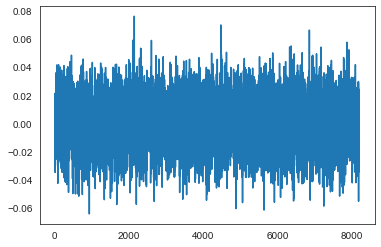

In [6]:
plt.plot(sx)

#### When averaging by changing the shape of the signal. Should It be averaged for every observable we will be looking for? 
#### Should we average and then make the required transformations or usage in functions or the other way around?

In [7]:
Fx = np.fft.rfft(sx)
Fy = np.fft.rfft(sy)
def PS (a,b=None):
    if b is None:
        prod = np.real(a*np.conj(a))
    else:
        prod = a*np.conj(b)
    binPk = prod[1:].reshape((2**5,-1)).mean(axis=-1)
    
    return binPk

In [8]:
Pxx = PS(Fx)
Pyy = PS(Fy)
Pxy = PS(Fx,Fy)
I = Pxx+Pyy
Q = Pxx-Pyy
U = 2*np.real(Pxy)    # from wikipedia
V = -2*np.imag(Pxy)
N = np.mean(I)
I/=N
Q/=N
U/=N
V/=N

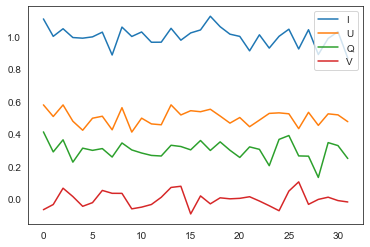

In [9]:
plt.plot(I,label="I")
plt.plot(U,label="U")
plt.plot(Q,label="Q")
plt.plot(V,label="V")
plt.legend()


In [10]:
# Define change in angle here
c = 3e8

def faraday_rotation_angle(w):
    if w==0:
        far_angle = 0
    else:
        far_angle = 0.01*c/w
    
    return far_angle

In [11]:
len(sx)

8192

In [12]:
time = np.linspace(0.0,0.01,len(sx),endpoint=False)
npts = len(time)

In [13]:
k = np.fft.rfftfreq(len(time))
kfreq = k*npts/(max(time)+time[1])  #Frequncies on the axis.

In [14]:
len(kfreq)

4097

###### Showing the difference between two frequencies on the freq axis.

In [15]:
kfreq[3]-kfreq[2]

100.0

In [16]:
print(kfreq)

[0.000e+00 1.000e+02 2.000e+02 ... 4.094e+05 4.095e+05 4.096e+05]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


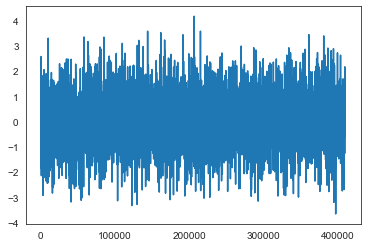

In [17]:
plt.plot(kfreq,Fx)

In [18]:
max(kfreq)

409600.0

In [19]:
Fx1 = Fx.copy()    ## Making the copies so that I don't alter the original signal by mistake
Fy1 = Fy.copy()
Fx2 = Fx.copy()
Fy2 = Fy.copy()

### Defining the faraday rotation angle

In [20]:


far_rot = np.zeros(len(kfreq))
for i in range(len(kfreq)):
    far_rot[i] = faraday_rotation_angle(kfreq[i])
    Fx2[i] = Fx1[i]*np.cos(far_rot[i])+Fy1[i]*np.sin(far_rot[i])
    Fy2[i] = -Fx1[i]*np.sin(far_rot[i])+Fy1[i]*np.cos(far_rot[i])
    
## Fx2 and Fy2 are the final signals in fourier space after faraday rotation

In [21]:
sx1 = np.fft.irfft(Fx2)
sy1 = np.fft.irfft(Fy2)
len(sx1)
## sx1 and sy1 are signals in time space after faraday rotation with 

8192

####  Stokes parameters after Far. rotation

In [22]:
Pxx1 = PS(Fx2)
Pyy1 = PS(Fy2)
Pxy1 = PS(Fx2,Fy2)
I1 = Pxx1+Pyy1
Q1 = Pxx1-Pyy1
U1 = 2*np.real(Pxy1)
V1 = -2*np.imag(Pxy1)
N1 = np.mean(I1)
I1/=N1
Q1/=N1
U1/=N1
V1/=N1

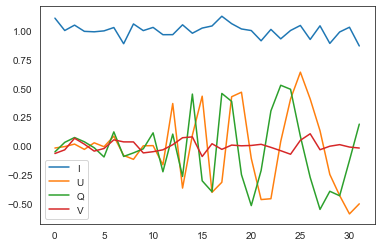

In [23]:
plt.plot(I1,label="I")
plt.plot(U1,label="U")
plt.plot(Q1,label="Q")
plt.plot(V1,label="V")
plt.legend()


#### The U and Q are the ones that are varied during faraday rotation and they have changed a lot compared to their respective values before rotation

### IN the four cells below this, I'm trying to see if by averaging before would it make any sense. I was following your lead on length of 32, maybe this can be changed

In [24]:
binPks = sx1.reshape((2**5,-1)).mean(axis=-1)

In [25]:
binPkfre = kfreq[1:len(kfreq)].reshape((2**5,-1)).mean(axis=-1)

In [26]:
far_rot2 = far_rot[1:len(far_rot)].reshape((2**5,-1)).mean(axis=-1)
#for i in range(len(binPkfre)):
    
 #   far_rot2[i] = faraday_rotation_angle(binPkfre[i])

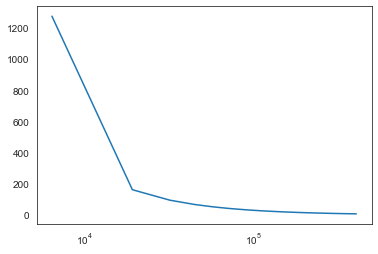

In [27]:
plt.semilogx(binPkfre,far_rot2)

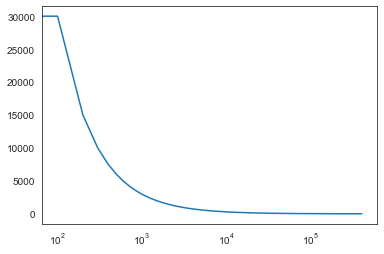

In [28]:
plt.semilogx(kfreq,far_rot)

## The PFB part starts here, for a start I was using the basic code that was written in the PFB introductory jupyter notebook https://github.com/telegraphic/pfb_introduction and trying to see if I can include our data into that basic code. 


In [29]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

In [30]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

In [31]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

In [32]:
def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

In [33]:
data = sy1
M = 2**4
P = 2**4
W = 1000

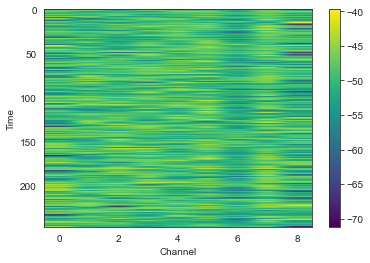

[[4.12180131e-06 9.52674800e-06 1.57943899e-05 ... 8.25301586e-06
  1.30702233e-05 4.89843732e-06]
 [1.55808101e-05 2.96480473e-05 5.03739869e-06 ... 9.25464959e-06
  2.13526335e-05 5.85071881e-06]
 [2.69579518e-05 8.27914278e-06 1.56196285e-05 ... 2.64539362e-06
  2.31678418e-05 4.74624677e-05]
 ...
 [1.28911097e-05 1.60928074e-05 1.36310015e-05 ... 8.61190158e-06
  2.92142930e-06 5.89744265e-06]
 [5.21987728e-06 6.04235794e-06 7.65387725e-06 ... 9.45261090e-06
  1.18742674e-05 1.03912063e-05]
 [4.59726538e-05 8.75070499e-06 7.91961365e-06 ... 1.14443922e-05
  2.00433880e-05 8.65290634e-08]]


In [34]:
X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=2, window_fn="hamming")

plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.show()
print(X_psd)

### THe main issue I was facing with in these plots is the choice of  numbers M,P,W that needs to be given. If the numbers are out of a certain range, it returns an empty array, exmaple is given at the end of this notebook

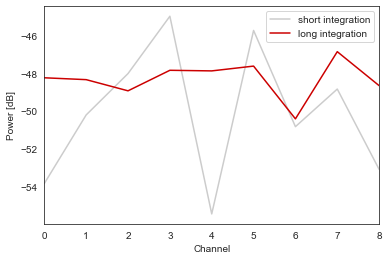

[4.12180131e-06 9.52674800e-06 1.57943899e-05 3.18249158e-05
 2.84143305e-06 2.67567925e-05 8.25301586e-06 1.30702233e-05
 4.89843732e-06]


248

In [35]:
X_psd2 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=200, window_fn="hamming")

plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
plt.plot(db(X_psd2[0]), c='#cc0000', label='long integration')
#plt.ylim(-20, -10)
plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()
#print(X_psd2)
print(X_psd[0])
len(X_psd)

### I don't know what to make of it but it rather looks like noise rather than an original signal of interest

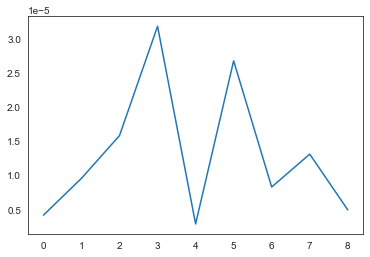

In [36]:
plt.plot(X_psd[0])

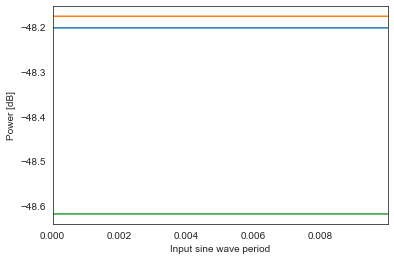

In [37]:
M, P, W = 16, 16, 256                   # taps, channels, windows
period = np.linspace(0, 0.025, 101)

chan0_val = []
chan1_val = []
chan2_val = []
for p in time:
    t = np.arange(0, M*P*W)
    x = np.sin(t * p) + 0.001
    X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=256, window_fn="hamming")
    chan0_val.append(X_psd[0, 0])
    chan1_val.append(X_psd[0, 1])
    chan2_val.append(X_psd[0, 2])
    
    
plt.plot(time, db(chan0_val))
plt.plot(time, db(chan1_val))
plt.plot(time, db(chan2_val))
plt.xlim(time[0], time[-1])
plt.ylabel("Power [dB]")
plt.xlabel("Input sine wave period")
plt.show()

In [38]:
M = 128
P = 128

In [39]:
X_psd3 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=200, window_fn="hamming")

plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
plt.plot(db(X_psd2[0]), c='#cc0000', label='long integration')
#plt.ylim(-20, -10)
plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()
#print(X_psd2)
print(X_psd[0])
len(X_psd)

ValueError: cannot reshape array of size 8192 into shape (0,128)

## If I average and took only 32 values, wouldn't that change the way we can break our signal into i.e the values of M and P by a lot?

In [48]:
data1 = binPks
M1 = 2
P1 = 8
W1 = 100

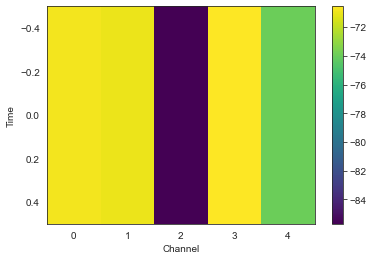

[[8.23532201e-08 7.92927819e-08 2.69366017e-09 8.79292898e-08
  4.00528089e-08]]


In [49]:
X_psd = pfb_spectrometer(data1, n_taps=M1, n_chan=P1, n_int=2, window_fn="hamming")

plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.show()
print(X_psd)

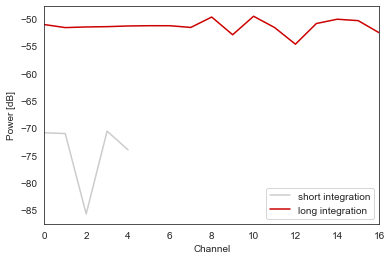

[8.23532201e-08 7.92927819e-08 2.69366017e-09 8.79292898e-08
 4.00528089e-08]


1

In [50]:
X_psd2 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=200, window_fn="hamming")

plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
plt.plot(db(X_psd2[0]), c='#cc0000', label='long integration')
#plt.ylim(-20, -10)
plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()
#print(X_psd2)
print(X_psd[0])
len(X_psd)